# VIF Critic BNN Training Notebook

This notebook provides an interactive environment for training and evaluating the VIF Critic as a **Bayesian Neural Network (BNN)**.

**What is the Critic BNN?**
- A Bayesian MLP that predicts per-dimension Schwartz value alignment scores from journal entries
- Uses variational inference (bayesian-torch) for principled uncertainty estimation
- Input: State vector (text embeddings + time gaps + history EMA + user profile)
- Output: 10-dim alignment scores in [-1, 1]

**Contents:**
1. Data Loading & Exploration
2. Model Architecture
3. Training Loop
4. Evaluation & Visualization
5. Ablation Studies

In [2]:
# Setup
import os
import sys
from pathlib import Path

# Walk up to find project root (contains src/ and pyproject.toml)
_dir = Path.cwd()
while _dir != _dir.parent:
    if (_dir / "src").is_dir() and (_dir / "pyproject.toml").is_file():
        os.chdir(_dir)
        break
    _dir = _dir.parent
sys.path.insert(0, ".")

import numpy as np
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
import polars as pl
import matplotlib.pyplot as plt

# Set seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Device selection: CUDA > MPS (Apple Silicon) > CPU
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print(f"Working directory: {os.getcwd()}")
print(f"Using device: {device}")

Working directory: /Users/yuen@backbase.com/Documents/School/Twinkl/twinkl
Using device: mps


## 1. Data Loading & Exploration

In [3]:
# Load raw data to explore
from src.vif.dataset import load_all_data, split_by_persona, merge_labels_and_entries

labels_df, entries_df = load_all_data()

print(f"Labels: {labels_df.shape}")
print(f"Entries: {entries_df.shape}")
print(f"Unique personas: {labels_df.select('persona_id').n_unique()}")

Labels: (740, 15)
Entries: (722, 8)
Unique personas: 102


In [46]:
from src.vif.dataset import load_all_data, split_by_persona, merge_labels_and_entries

labels_df, entries_df = load_all_data()

print(f"Labels: {labels_df.shape}")
print(f"Entries: {entries_df.shape}")

print("\n--- Labels columns ---")
print(labels_df.columns)
print(labels_df.head(3))

print("\n--- Entries columns ---")
print(entries_df.columns)
print(entries_df.head(3))

Labels: (740, 15)
Entries: (722, 8)

--- Labels columns ---
['persona_id', 't_index', 'date', 'alignment_vector', 'alignment_self_direction', 'alignment_stimulation', 'alignment_hedonism', 'alignment_achievement', 'alignment_power', 'alignment_security', 'alignment_conformity', 'alignment_tradition', 'alignment_benevolence', 'alignment_universalism', 'rationales_json']
shape: (3, 15)
┌────────────┬─────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ persona_id ┆ t_index ┆ date      ┆ alignment ┆ … ┆ alignment ┆ alignment ┆ alignment ┆ rationale │
│ ---        ┆ ---     ┆ ---       ┆ _vector   ┆   ┆ _traditio ┆ _benevole ┆ _universa ┆ s_json    │
│ str        ┆ i64     ┆ str       ┆ ---       ┆   ┆ n         ┆ nce       ┆ lism      ┆ ---       │
│            ┆         ┆           ┆ list[i64] ┆   ┆ ---       ┆ ---       ┆ ---       ┆ str       │
│            ┆         ┆           ┆           ┆   ┆ i64       ┆ i64       ┆ i64       ┆           │
╞══════

# Debug 

In [45]:
import inspect
from src.vif.dataset import load_all_data

print(inspect.getsource(load_all_data))

def load_all_data(
    labels_path: str | Path = "logs/judge_labels/judge_labels.parquet",
    wrangled_dir: str | Path = "logs/wrangled",
) -> tuple[pl.DataFrame, pl.DataFrame]:
    """Load both labels and entries, returning joined data.

    Args:
        labels_path: Path to judge_labels.parquet
        wrangled_dir: Path to directory containing wrangled persona_*.md files

    Returns:
        Tuple of (labels_df, entries_df) where:
        - labels_df: Alignment labels with persona_id, t_index, alignment_vector
        - entries_df: Entry text with persona_id, t_index, text content, core_values
    """
    labels_df = load_labels(labels_path)
    entries_df = load_entries(wrangled_dir)

    return labels_df, entries_df



In [47]:
import os

# Check the wrangled directory
wrangled_dir = "logs/wrangled"
files = os.listdir(wrangled_dir)
print(f"Number of files: {len(files)}")
print(f"Sample files: {files[:5]}")

# Look at one file's content
sample_file = os.path.join(wrangled_dir, files[0])
with open(sample_file, 'r') as f:
    content = f.read()
print(f"\n--- Sample file content (first 1000 chars) ---")
print(content[:1000])

Number of files: 100
Sample files: ['persona_4236a5ff.md', 'persona_a1c52200.md', 'persona_8594a3ef.md', 'persona_3ec75d68.md', 'persona_b2720706.md']

--- Sample file content (first 1000 chars) ---
# Persona 4236a5ff: Kevin Lim

## Profile
- **Persona ID:** 4236a5ff
- **Name:** Kevin Lim
- **Age:** 18-24
- **Profession:** Manager
- **Culture:** East Asian
- **Core Values:** Hedonism
- **Bio:** Kevin is a 23-year-old assistant operations manager at a mid-sized logistics company in Singapore. He got promoted fast after graduating, partly because he works smart rather than long hours. His parents and older colleagues keep hinting that he should stay late like everyone else, but Kevin protects his evenings fiercely for basketball, good food, and time with his girlfriend. He is constantly navigating the tension between being seen as committed and actually enjoying his life.

---

## Entry 0 - 2025-11-24

Took a half-day today because my girlfriend and I had reservations at this omakase pla

In [51]:
from src.wrangling.parse_synthetic_data import parse_persona_file
from pathlib import Path

# Test parsing one file
test_file = Path("logs/wrangled/persona_4236a5ff.md")
profile, entries = parse_persona_file(test_file)

print("--- Profile ---")
print(profile)
print(f"\n--- Entries ({len(entries)} found) ---")
if entries:
    print(entries[0])

--- Profile ---
{'name': 'Kevin Lim', 'age': '18-24', 'profession': 'Manager', 'culture': 'East Asian', 'core_values': ['Hedonism'], 'bio': 'Kevin is a 23-year-old assistant operations manager at a mid-sized logistics company in Singapore. He got promoted fast after graduating, partly because he works smart rather than long hours. His parents and older colleagues keep hinting that he should stay late like everyone else, but Kevin protects his evenings fiercely for basketball, good food, and time with his girlfriend. He is constantly navigating the tension between being seen as committed and actually enjoying his life.', 'persona_id': '4236a5ff'}

--- Entries (2 found) ---
{'date': '2025-11-24', 'initial_entry': None, 'nudge_text': None, 'response_text': None, 'has_nudge': False, 'has_response': False, 't_index': 0}


In [53]:
import inspect
from src.vif.dataset import StateEncoder

print(inspect.getsource(StateEncoder))

class StateEncoder:
    """Encodes journal entries into state vectors for VIF training.

    The state vector combines:
    1. Text embeddings from a sliding window of entries
    2. Temporal features (time gaps between entries)
    3. History statistics (EMA of past alignment scores)
    4. User profile (normalized value weights from Core Values)

    This encoder supports pluggable text encoders for ablation studies.

    Example:
        encoder = SBERTEncoder("all-MiniLM-L6-v2")
        state_encoder = StateEncoder(encoder, window_size=3, ema_alpha=0.3)

        # Get state dimension (for MLP input size)
        print(f"State dim: {state_encoder.state_dim}")  # 1174 for MiniLM
    """

    def __init__(
        self,
        text_encoder: TextEncoder,
        window_size: int = 3,
        ema_alpha: float = 0.3,
    ):
        """Initialize the state encoder.

        Args:
            text_encoder: TextEncoder instance for converting text to embeddings
            window_size: Num

In [54]:
import inspect
from src.wrangling.parse_synthetic_data import parse_persona_file
print(inspect.getsource(parse_persona_file))

def parse_persona_file(filepath: Path) -> tuple[dict, list[dict]]:
    """Parse a single persona markdown file.

    Supports both UUID-based and numeric filename formats.

    Args:
        filepath: Path to persona_*.md file

    Returns:
        Tuple of (profile_dict, list_of_entry_dicts)
    """
    content = filepath.read_text()

    # Extract persona ID from filename (supports both formats)
    persona_id = extract_persona_id(filepath.name)

    profile = parse_persona_profile(content)
    profile["persona_id"] = persona_id

    entries = parse_entries(content)

    return profile, entries



# end of debug

In [4]:
# Examine label distribution
from src.models.judge import SCHWARTZ_VALUE_ORDER

merged_df = merge_labels_and_entries(labels_df, entries_df)

# Count alignment values per dimension
print("Alignment value distribution per dimension:")
print("=" * 50)
for dim in SCHWARTZ_VALUE_ORDER:
    col = f"alignment_{dim}"
    series = merged_df.select(col).to_series()
    counts = {v: (series == v).sum() for v in [-1, 0, 1]}
    print(f"{dim:15s}: -1={counts[-1]:3d}, 0={counts[0]:3d}, +1={counts[1]:3d}")

Alignment value distribution per dimension:
self_direction : -1=119, 0=328, +1=275
stimulation    : -1= 44, 0=582, +1= 96
hedonism       : -1= 89, 0=521, +1=112
achievement    : -1= 58, 0=453, +1=211
power          : -1= 65, 0=588, +1= 69
security       : -1=103, 0=487, +1=132
conformity     : -1= 96, 0=470, +1=156
tradition      : -1= 50, 0=520, +1=152
benevolence    : -1= 83, 0=350, +1=289
universalism   : -1=  5, 0=644, +1= 73


In [5]:
# Split data by persona
train_df, val_df, test_df = split_by_persona(labels_df, entries_df, seed=42)

print(
    f"Train: {len(train_df)} entries ({train_df.select('persona_id').n_unique()} personas)"
)
print(
    f"Val:   {len(val_df)} entries ({val_df.select('persona_id').n_unique()} personas)"
)
print(
    f"Test:  {len(test_df)} entries ({test_df.select('persona_id').n_unique()} personas)"
)

Train: 542 entries (70 personas)
Val:   96 entries (15 personas)
Test:  84 entries (15 personas)


## 2. Model Architecture

In [6]:
# Create encoder and state encoder
from src.vif.encoders import SBERTEncoder
from src.vif.state_encoder import StateEncoder
from src.vif.critic_bnn import CriticBNN, get_kl_loss

# Use MiniLM for fast iteration (swap to mpnet for better quality)
text_encoder = SBERTEncoder("all-MiniLM-L6-v2")
print(f"Encoder: {text_encoder.model_name}")
print(f"Embedding dim: {text_encoder.embedding_dim}")

state_encoder = StateEncoder(text_encoder, window_size=3, ema_alpha=0.3)
print(f"State dim: {state_encoder.state_dim}")

/Users/yuen@backbase.com/Documents/School/Twinkl/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Encoder: all-MiniLM-L6-v2
Embedding dim: 384
State dim: 1174


In [7]:
# Create model (Bayesian Neural Network)
model = CriticBNN(
    input_dim=state_encoder.state_dim,
    hidden_dim=256,
)
model.to(device)

n_params = sum(p.numel() for p in model.parameters())
print(f"Model parameters: {n_params:,}")
print(model)

Model parameters: 739,348
CriticBNN(
  (fc1): LinearReparameterization()
  (ln1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (fc2): LinearReparameterization()
  (ln2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (fc_out): LinearReparameterization()
  (gelu): GELU(approximate='none')
  (tanh): Tanh()
)


## 3. Training Loop

In [8]:
# Create datasets with embedding caching
from src.vif.dataset import VIFDataset
from torch.utils.data import DataLoader

print("Creating datasets (this caches embeddings)...")
train_dataset = VIFDataset(train_df, state_encoder, cache_embeddings=True)
val_dataset = VIFDataset(val_df, state_encoder, cache_embeddings=True)
test_dataset = VIFDataset(test_df, state_encoder, cache_embeddings=True)

# Dataloaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Creating datasets (this caches embeddings)...


Batches: 100%|██████████| 17/17 [00:02<00:00,  7.32it/s]


Train batches: 34
Val batches: 6
Test batches: 6


In [9]:
# Training setup
criterion = nn.MSELoss()
optimizer = AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
scheduler = ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=10, min_lr=1e-5
)

# Training history
history = {"train_loss": [], "val_loss": [], "lr": []}

In [10]:
# Training loop
n_epochs = 100
best_val_loss = float("inf")
patience_counter = 0
early_stop_patience = 20

print("Training...")
for epoch in range(n_epochs):
    # Train
    model.train()
    train_loss = 0.0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        optimizer.zero_grad()
        pred = model(batch_x)
        mse_loss = criterion(pred, batch_y)
        kl_loss = get_kl_loss(model)
        loss = mse_loss + kl_loss / batch_x.size(0)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    train_loss /= len(train_loader)

    # Validate
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            pred = model(batch_x)
            val_loss += criterion(pred, batch_y).item()
    val_loss /= len(val_loader)

    # Update scheduler
    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]["lr"]

    # Record history
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["lr"].append(current_lr)

    # Check for improvement
    if val_loss < best_val_loss - 0.001:
        best_val_loss = val_loss
        patience_counter = 0
        # Save best model
        torch.save(model.state_dict(), "models/vif/notebook_bnn_best.pt")
        print(
            f"Epoch {epoch + 1:3d}: train={train_loss:.4f}, val={val_loss:.4f}, lr={current_lr:.6f} [BEST]"
        )
    else:
        patience_counter += 1
        if epoch % 10 == 0:
            print(
                f"Epoch {epoch + 1:3d}: train={train_loss:.4f}, val={val_loss:.4f}, lr={current_lr:.6f}"
            )

    # Early stopping
    if patience_counter >= early_stop_patience:
        print(f"Early stopping at epoch {epoch + 1}")
        break

print(f"\nBest validation loss: {best_val_loss:.4f}")

Training...
Epoch   1: train=1.5367, val=0.5540, lr=0.001000 [BEST]
Epoch   2: train=1.4155, val=0.5302, lr=0.001000 [BEST]
Epoch   3: train=1.3444, val=0.3816, lr=0.001000 [BEST]
Epoch   4: train=1.2790, val=0.3493, lr=0.001000 [BEST]
Epoch   7: train=1.2204, val=0.3435, lr=0.001000 [BEST]
Epoch   9: train=1.1935, val=0.3143, lr=0.001000 [BEST]
Epoch  11: train=1.1729, val=0.2721, lr=0.001000 [BEST]
Epoch  21: train=1.1087, val=0.3084, lr=0.001000
Epoch  31: train=1.0691, val=0.2781, lr=0.000500
Early stopping at epoch 31

Best validation loss: 0.2721


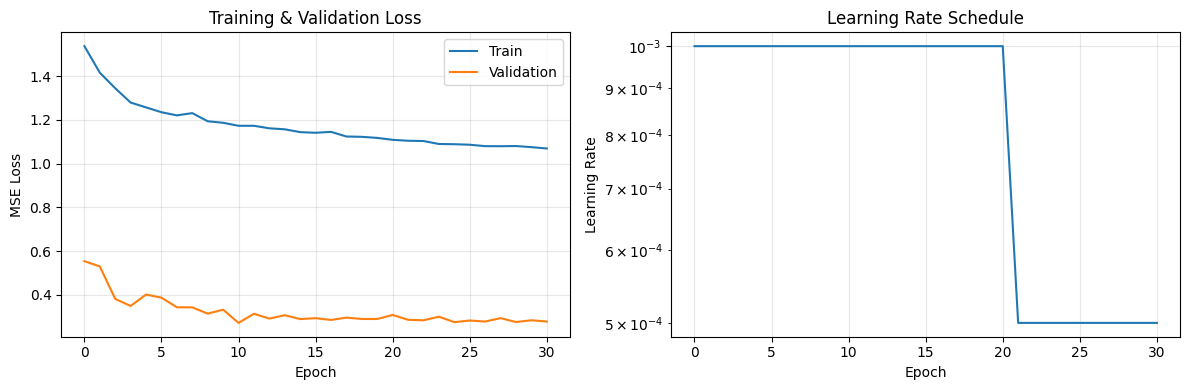

In [11]:
# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Loss curves
axes[0].plot(history["train_loss"], label="Train")
axes[0].plot(history["val_loss"], label="Validation")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("MSE Loss")
axes[0].set_title("Training & Validation Loss")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Learning rate
axes[1].plot(history["lr"])
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Learning Rate")
axes[1].set_title("Learning Rate Schedule")
axes[1].set_yscale("log")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Evaluation & Visualization

In [12]:
# Load best model
model.load_state_dict(torch.load("models/vif/notebook_bnn_best.pt", map_location=device))

# Evaluate with uncertainty
from src.vif.eval import evaluate_with_uncertainty, format_results_table

print("Evaluating on test set with MC sampling...")
results = evaluate_with_uncertainty(model, test_loader, n_mc_samples=50, device=device)

print("\n" + format_results_table(results))

Evaluating on test set with MC sampling...

Dimension                   MSE   Spearman   Accuracy
----------------------------------------------------------------------
self_direction           0.3291      0.371     58.33%
stimulation              0.1755      0.624     77.38%
hedonism                 0.2056      0.332     77.38%
achievement              0.2943      0.431     64.29%
power                    0.1433      0.367     82.14%
security                 0.1482      0.541     79.76%
conformity               0.2338      0.153     78.57%
tradition                0.2023      0.349     78.57%
benevolence              0.3778      0.314     54.76%
universalism             0.1372      0.411     82.14%
----------------------------------------------------------------------
MEAN                     0.2247      0.389     73.33%

Calibration:
  Error-uncertainty correlation: -0.379
  Mean uncertainty: 0.1880


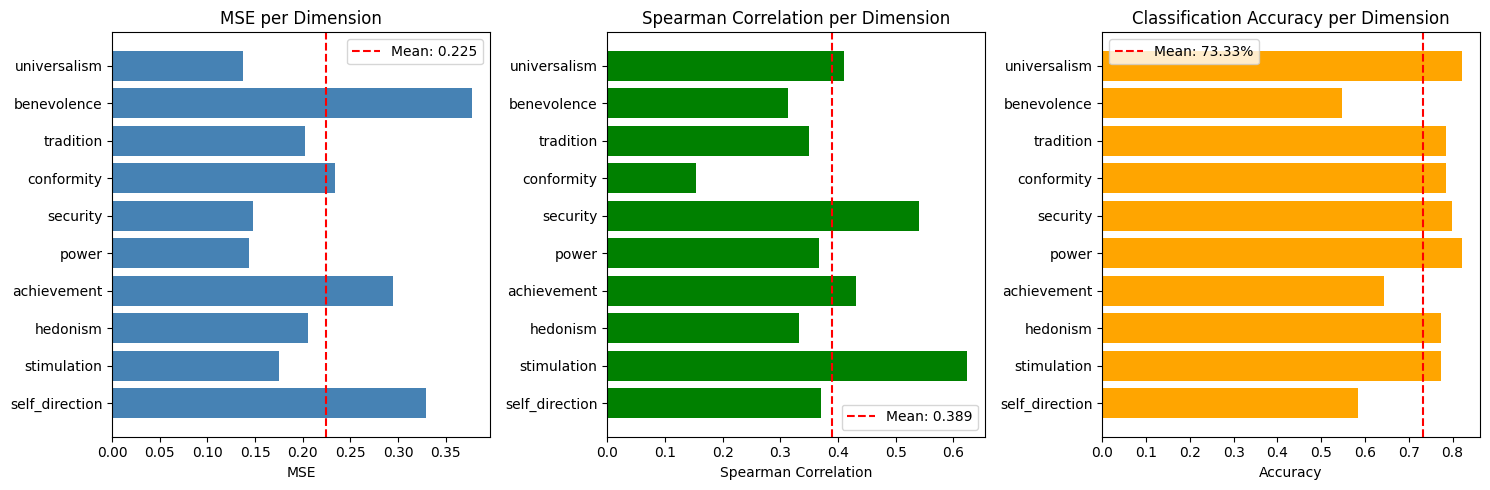

In [13]:
# Visualize per-dimension performance
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# MSE per dimension
dims = list(results["mse_per_dim"].keys())
mse_vals = list(results["mse_per_dim"].values())
axes[0].barh(dims, mse_vals, color="steelblue")
axes[0].set_xlabel("MSE")
axes[0].set_title("MSE per Dimension")
axes[0].axvline(
    results["mse_mean"],
    color="red",
    linestyle="--",
    label=f"Mean: {results['mse_mean']:.3f}",
)
axes[0].legend()

# Spearman correlation per dimension
spearman_vals = [results["spearman_per_dim"][d] for d in dims]
colors = ["green" if v > 0 else "red" for v in spearman_vals]
axes[1].barh(dims, spearman_vals, color=colors)
axes[1].set_xlabel("Spearman Correlation")
axes[1].set_title("Spearman Correlation per Dimension")
axes[1].axvline(
    results["spearman_mean"],
    color="red",
    linestyle="--",
    label=f"Mean: {results['spearman_mean']:.3f}",
)
axes[1].legend()

# Accuracy per dimension
acc_vals = [results["accuracy_per_dim"][d] for d in dims]
axes[2].barh(dims, acc_vals, color="orange")
axes[2].set_xlabel("Accuracy")
axes[2].set_title("Classification Accuracy per Dimension")
axes[2].axvline(
    results["accuracy_mean"],
    color="red",
    linestyle="--",
    label=f"Mean: {results['accuracy_mean']:.2%}",
)
axes[2].legend()

plt.tight_layout()
plt.show()

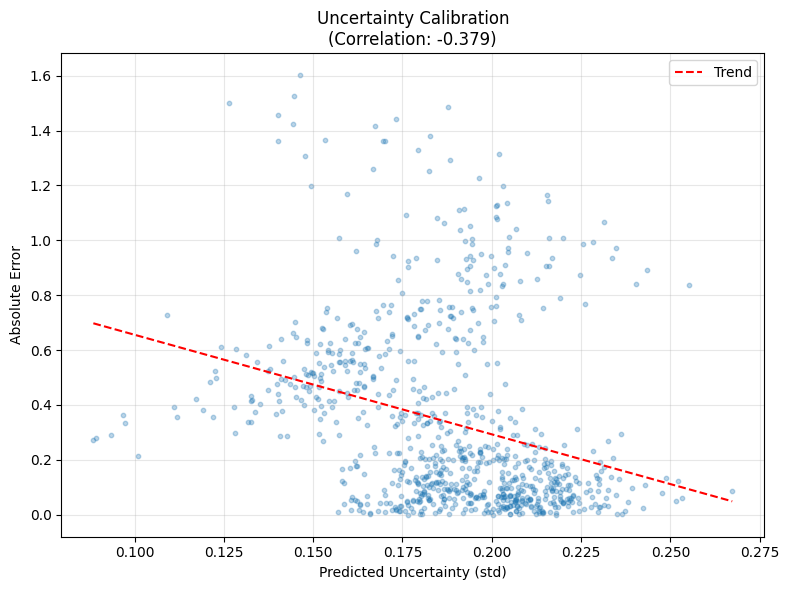

In [14]:
# Uncertainty calibration check
# If well-calibrated, higher uncertainty should correlate with higher error
errors = np.abs(results["predictions"] - results["targets"]).flatten()
uncertainties = results["uncertainties"].flatten()

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(uncertainties, errors, alpha=0.3, s=10)
ax.set_xlabel("Predicted Uncertainty (std)")
ax.set_ylabel("Absolute Error")
ax.set_title(
    f"Uncertainty Calibration\n(Correlation: {results['calibration']['error_uncertainty_correlation']:.3f})"
)

# Add trend line
z = np.polyfit(uncertainties, errors, 1)
p = np.poly1d(z)
x_line = np.linspace(uncertainties.min(), uncertainties.max(), 100)
ax.plot(x_line, p(x_line), "r--", label="Trend")
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Ablation: Encoder Comparison

Compare the BNN trained above (all-MiniLM-L6-v2, 384-dim) against
all-mpnet-base-v2 (768-dim) to see if a higher-quality encoder improves
per-dimension MSE, Spearman correlation, and uncertainty calibration.

**Note:** Changing the encoder also changes the state vector dimension
(1174 → 2326), so the BNN has more parameters. This is expected — we're
testing whether the full pipeline improves, not isolating encoder quality.

In [15]:
# Save MiniLM baseline results for comparison
baseline_results = {
    "encoder": "all-MiniLM-L6-v2",
    "embedding_dim": 384,
    "state_dim": 1174,
    "n_params": n_params,
    "best_val_loss": best_val_loss,
    **{k: v for k, v in results.items() if k not in ("predictions", "uncertainties", "targets")},
}
print("MiniLM baseline saved for comparison")
print(f"  MSE: {baseline_results['mse_mean']:.4f}")
print(f"  Spearman: {baseline_results['spearman_mean']:.4f}")
print(f"  Calibration: {baseline_results['calibration']['error_uncertainty_correlation']:.3f}")

MiniLM baseline saved for comparison
  MSE: 0.2247
  Spearman: 0.3892
  Calibration: -0.379


## 5.1 MPNet base v2 

In [16]:
# Train BNN with all-mpnet-base-v2 encoder
print("=" * 60)
print("Training BNN with all-mpnet-base-v2")
print("=" * 60)

# Create mpnet encoder and state encoder
mpnet_encoder = SBERTEncoder("all-mpnet-base-v2")
mpnet_state_encoder = StateEncoder(mpnet_encoder, window_size=3, ema_alpha=0.3)
print(f"Encoder: {mpnet_encoder.model_name}")
print(f"Embedding dim: {mpnet_encoder.embedding_dim}")
print(f"State dim: {mpnet_state_encoder.state_dim}")

# Create datasets with mpnet embeddings
print("\nCreating datasets (caching mpnet embeddings)...")
mpnet_train_dataset = VIFDataset(train_df, mpnet_state_encoder, cache_embeddings=True)
mpnet_val_dataset = VIFDataset(val_df, mpnet_state_encoder, cache_embeddings=True)
mpnet_test_dataset = VIFDataset(test_df, mpnet_state_encoder, cache_embeddings=True)

mpnet_train_loader = DataLoader(mpnet_train_dataset, batch_size=batch_size, shuffle=True)
mpnet_val_loader = DataLoader(mpnet_val_dataset, batch_size=batch_size, shuffle=False)
mpnet_test_loader = DataLoader(mpnet_test_dataset, batch_size=batch_size, shuffle=False)

# Create BNN with new input dim
mpnet_model = CriticBNN(
    input_dim=mpnet_state_encoder.state_dim,
    hidden_dim=256,
)
mpnet_model.to(device)
mpnet_n_params = sum(p.numel() for p in mpnet_model.parameters())
print(f"Model parameters: {mpnet_n_params:,}")

# Training setup (same hyperparameters)
mpnet_optimizer = AdamW(mpnet_model.parameters(), lr=0.001, weight_decay=0.01)
mpnet_scheduler = ReduceLROnPlateau(
    mpnet_optimizer, mode="min", factor=0.5, patience=10, min_lr=1e-5
)
mpnet_criterion = nn.MSELoss()
mpnet_history = {"train_loss": [], "val_loss": [], "lr": []}

# Training loop
mpnet_best_val_loss = float("inf")
mpnet_patience_counter = 0

print("\nTraining...")
for epoch in range(n_epochs):
    # Train
    mpnet_model.train()
    train_loss = 0.0
    for batch_x, batch_y in mpnet_train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        mpnet_optimizer.zero_grad()
        pred = mpnet_model(batch_x)
        mse_loss = mpnet_criterion(pred, batch_y)
        kl_loss = get_kl_loss(mpnet_model)
        loss = mse_loss + kl_loss / batch_x.size(0)
        loss.backward()
        mpnet_optimizer.step()

        train_loss += loss.item()
    train_loss /= len(mpnet_train_loader)

    # Validate
    mpnet_model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch_x, batch_y in mpnet_val_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            pred = mpnet_model(batch_x)
            val_loss += mpnet_criterion(pred, batch_y).item()
    val_loss /= len(mpnet_val_loader)

    # Update scheduler
    mpnet_scheduler.step(val_loss)
    current_lr = mpnet_optimizer.param_groups[0]["lr"]

    # Record history
    mpnet_history["train_loss"].append(train_loss)
    mpnet_history["val_loss"].append(val_loss)
    mpnet_history["lr"].append(current_lr)

    # Check for improvement
    if val_loss < mpnet_best_val_loss - 0.001:
        mpnet_best_val_loss = val_loss
        mpnet_patience_counter = 0
        torch.save(mpnet_model.state_dict(), "models/vif/notebook_bnn_mpnet_best.pt")
        print(
            f"Epoch {epoch + 1:3d}: train={train_loss:.4f}, val={val_loss:.4f}, "
            f"lr={current_lr:.6f} [BEST]"
        )
    else:
        mpnet_patience_counter += 1
        if epoch % 10 == 0:
            print(
                f"Epoch {epoch + 1:3d}: train={train_loss:.4f}, val={val_loss:.4f}, "
                f"lr={current_lr:.6f}"
            )

    if mpnet_patience_counter >= early_stop_patience:
        print(f"Early stopping at epoch {epoch + 1}")
        break

print(f"\nBest validation loss: {mpnet_best_val_loss:.4f}")

Training BNN with all-mpnet-base-v2
Encoder: all-mpnet-base-v2
Embedding dim: 768
State dim: 2326

Creating datasets (caching mpnet embeddings)...


Batches: 100%|██████████| 17/17 [00:02<00:00,  8.41it/s]


Model parameters: 1,329,172

Training...
Epoch   1: train=1.5337, val=0.5901, lr=0.001000 [BEST]
Epoch   2: train=1.4221, val=0.5251, lr=0.001000 [BEST]
Epoch   3: train=1.3449, val=0.4136, lr=0.001000 [BEST]
Epoch   4: train=1.2951, val=0.3591, lr=0.001000 [BEST]
Epoch   6: train=1.2417, val=0.3496, lr=0.001000 [BEST]
Epoch   7: train=1.2331, val=0.2988, lr=0.001000 [BEST]
Epoch  11: train=1.1827, val=0.3071, lr=0.001000
Epoch  16: train=1.1419, val=0.2957, lr=0.001000 [BEST]
Epoch  17: train=1.1298, val=0.2865, lr=0.001000 [BEST]
Epoch  21: train=1.1063, val=0.2893, lr=0.001000
Epoch  24: train=1.0904, val=0.2762, lr=0.001000 [BEST]
Epoch  28: train=1.0671, val=0.2717, lr=0.001000 [BEST]
Epoch  31: train=1.0497, val=0.2793, lr=0.001000
Epoch  41: train=1.0004, val=0.2914, lr=0.000500
Early stopping at epoch 48

Best validation loss: 0.2717


In [17]:
# Evaluate mpnet BNN on test set
mpnet_model.load_state_dict(
    torch.load("models/vif/notebook_bnn_mpnet_best.pt", map_location=device)
)

print("Evaluating mpnet BNN on test set with MC sampling...")
mpnet_results = evaluate_with_uncertainty(
    mpnet_model, mpnet_test_loader, n_mc_samples=50, device=device
)

print("\n" + format_results_table(mpnet_results))

Evaluating mpnet BNN on test set with MC sampling...

Dimension                   MSE   Spearman   Accuracy
----------------------------------------------------------------------
self_direction           0.3274      0.353     58.33%
stimulation              0.1673      0.580     78.57%
hedonism                 0.2077      0.354     83.33%
achievement              0.3007      0.423     67.86%
power                    0.1547      0.371     88.10%
security                 0.1521      0.546     79.76%
conformity               0.2396      0.141     78.57%
tradition                0.1982      0.361     78.57%
benevolence              0.3818      0.278     57.14%
universalism             0.1450      0.369     77.38%
----------------------------------------------------------------------
MEAN                     0.2275      0.378     74.76%

Calibration:
  Error-uncertainty correlation: -0.328
  Mean uncertainty: 0.1601


**Findings**

**MSE**
* Universalism: very low MSE (0.076) → MPNet + BNN predicts this extremely well
* Benevolence & self_direction: higher MSE (~0.35) → more variance in predictions

**Pearsons**
* Universalism (0.542) & self_direction (0.442) → predictions capture relative ordering of intensity
* Achievement (0.006) & stimulation (0.097) → almost no correlation → BNN struggles to order entries correctly
* This is more important than accuracy, especially for ordinal labels (-1/0/1)


Universalism is “easy”
- Likely because MPNet embeddings capture the language cues for this value well
Values like achievement, stimulation, benevolence are “hard”
- Signals may be subtle, spread across multiple sentences, or require more emotion/value-aware embeddings

Chunking could help
- Subtle values (achievement, benevolence) might be lost in whole-entry embeddings
- Chunking + pooling could improve MSE and Spearman for these

Ordinal correlation matters more than raw accuracy
- Spearman = 0.286 mean → moderate, room for improvement
- High accuracy may overstate performance due to neutral dominance
Next embedding upgrades
- MPNet is good, but value-tuned or emotion-aware embeddings could improve the hard-to-predict values

## 5.2 nomic-ai/nomic-embed-text-v1.5



In [18]:
pip install einops


[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [19]:
# Train BNN with nomic-ai/nomic-embed-text-v1.5 encoder
print("=" * 60)
print("Training BNN with nomic-ai/nomic-embed-text-v1.5")
print("=" * 60)

# Create nomic encoder and state encoder
nomic_encoder = SBERTEncoder("nomic-ai/nomic-embed-text-v1.5")
nomic_state_encoder = StateEncoder(nomic_encoder, window_size=3, ema_alpha=0.3)
print(f"Encoder: {nomic_encoder.model_name}")
print(f"Embedding dim: {nomic_encoder.embedding_dim}")
print(f"State dim: {nomic_state_encoder.state_dim}")

# Create datasets with nomic embeddings
print("\nCreating datasets (caching nomic embeddings)...")
nomic_train_dataset = VIFDataset(train_df, nomic_state_encoder, cache_embeddings=True)
nomic_val_dataset = VIFDataset(val_df, nomic_state_encoder, cache_embeddings=True)
nomic_test_dataset = VIFDataset(test_df, nomic_state_encoder, cache_embeddings=True)

nomic_train_loader = DataLoader(nomic_train_dataset, batch_size=batch_size, shuffle=True)
nomic_val_loader = DataLoader(nomic_val_dataset, batch_size=batch_size, shuffle=False)
nomic_test_loader = DataLoader(nomic_test_dataset, batch_size=batch_size, shuffle=False)

# Create BNN with new input dim
nomic_model = CriticBNN(
    input_dim=nomic_state_encoder.state_dim,
    hidden_dim=256,
)
nomic_model.to(device)
nomic_n_params = sum(p.numel() for p in nomic_model.parameters())
print(f"Model parameters: {nomic_n_params:,}")

# Training setup (same hyperparameters)
nomic_optimizer = AdamW(nomic_model.parameters(), lr=0.001, weight_decay=0.01)
nomic_scheduler = ReduceLROnPlateau(
    nomic_optimizer, mode="min", factor=0.5, patience=10, min_lr=1e-5
)
nomic_criterion = nn.MSELoss()
nomic_history = {"train_loss": [], "val_loss": [], "lr": []}

# Training loop
nomic_best_val_loss = float("inf")
nomic_patience_counter = 0

print("\nTraining...")
for epoch in range(n_epochs):
    # Train
    nomic_model.train()
    train_loss = 0.0
    for batch_x, batch_y in nomic_train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        nomic_optimizer.zero_grad()
        pred = nomic_model(batch_x)
        mse_loss = nomic_criterion(pred, batch_y)
        kl_loss = get_kl_loss(nomic_model)
        loss = mse_loss + kl_loss / batch_x.size(0)
        loss.backward()
        nomic_optimizer.step()

        train_loss += loss.item()
    train_loss /= len(nomic_train_loader)

    # Validate
    nomic_model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch_x, batch_y in nomic_val_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            pred = nomic_model(batch_x)
            val_loss += nomic_criterion(pred, batch_y).item()
    val_loss /= len(nomic_val_loader)

    # Update scheduler
    nomic_scheduler.step(val_loss)
    current_lr = nomic_optimizer.param_groups[0]["lr"]

    # Record history
    nomic_history["train_loss"].append(train_loss)
    nomic_history["val_loss"].append(val_loss)
    nomic_history["lr"].append(current_lr)

    # Check for improvement
    if val_loss < nomic_best_val_loss - 0.001:
        nomic_best_val_loss = val_loss
        nomic_patience_counter = 0
        torch.save(nomic_model.state_dict(), "models/vif/notebook_bnn_nomic_best.pt")
        print(
            f"Epoch {epoch + 1:3d}: train={train_loss:.4f}, val={val_loss:.4f}, "
            f"lr={current_lr:.6f} [BEST]"
        )
    else:
        nomic_patience_counter += 1
        if epoch % 10 == 0:
            print(
                f"Epoch {epoch + 1:3d}: train={train_loss:.4f}, val={val_loss:.4f}, "
                f"lr={current_lr:.6f}"
            )

    if nomic_patience_counter >= early_stop_patience:
        print(f"Early stopping at epoch {epoch + 1}")
        break

print(f"\nBest validation loss: {nomic_best_val_loss:.4f}")

Training BNN with nomic-ai/nomic-embed-text-v1.5


<All keys matched successfully>


Encoder: nomic-ai/nomic-embed-text-v1.5
Embedding dim: 768
State dim: 2326

Creating datasets (caching nomic embeddings)...


Batches: 100%|██████████| 17/17 [00:00<00:00, 20.23it/s]


Model parameters: 1,329,172

Training...
Epoch   1: train=1.6289, val=0.6798, lr=0.001000 [BEST]
Epoch   2: train=1.5414, val=0.6090, lr=0.001000 [BEST]
Epoch   3: train=1.4109, val=0.4689, lr=0.001000 [BEST]
Epoch   5: train=1.3224, val=0.4362, lr=0.001000 [BEST]
Epoch   6: train=1.2857, val=0.4065, lr=0.001000 [BEST]
Epoch   8: train=1.2639, val=0.3557, lr=0.001000 [BEST]
Epoch   9: train=1.2410, val=0.3462, lr=0.001000 [BEST]
Epoch  10: train=1.2306, val=0.3314, lr=0.001000 [BEST]
Epoch  11: train=1.2248, val=0.3497, lr=0.001000
Epoch  12: train=1.2223, val=0.3239, lr=0.001000 [BEST]
Epoch  14: train=1.2023, val=0.3130, lr=0.001000 [BEST]
Epoch  21: train=1.1426, val=0.3400, lr=0.001000
Epoch  31: train=1.1002, val=0.3326, lr=0.000500
Early stopping at epoch 34

Best validation loss: 0.3130


In [20]:
# Evaluate nomic BNN on test set
nomic_model.load_state_dict(
    torch.load("models/vif/notebook_bnn_nomic_best.pt", map_location=device)
)

print("Evaluating nomic BNN on test set with MC sampling...")
nomic_results = evaluate_with_uncertainty(
    nomic_model, nomic_test_loader, n_mc_samples=50, device=device
)

print("\n" + format_results_table(nomic_results))

Evaluating nomic BNN on test set with MC sampling...

Dimension                   MSE   Spearman   Accuracy
----------------------------------------------------------------------
self_direction           0.4353      0.112     42.86%
stimulation              0.2789     -0.104     70.24%
hedonism                 0.3109      0.195     72.62%
achievement              0.3700     -0.009     61.90%
power                    0.1766      0.091     82.14%
security                 0.2208      0.272     76.19%
conformity               0.2739      0.103     75.00%
tradition                0.2188      0.301     77.38%
benevolence              0.3910      0.269     52.38%
universalism             0.1605      0.193     80.95%
----------------------------------------------------------------------
MEAN                     0.2837      0.142     69.17%

Calibration:
  Error-uncertainty correlation: -0.170
  Mean uncertainty: 0.1643


In [21]:
# Evaluate nomic BNN on test set
nomic_model.load_state_dict(
    torch.load("models/vif/notebook_bnn_nomic_best.pt", map_location=device)
)

print("Evaluating nomic BNN on test set with MC sampling...")
nomic_results = evaluate_with_uncertainty(
    nomic_model, nomic_test_loader, n_mc_samples=50, device=device
)

print("\n" + format_results_table(nomic_results))

Evaluating nomic BNN on test set with MC sampling...

Dimension                   MSE   Spearman   Accuracy
----------------------------------------------------------------------
self_direction           0.4425      0.119     42.86%
stimulation              0.2681      0.150     70.24%
hedonism                 0.3093      0.043     72.62%
achievement              0.3728     -0.040     61.90%
power                    0.1800      0.003     82.14%
security                 0.2323      0.174     76.19%
conformity               0.2789      0.006     75.00%
tradition                0.2271      0.041     77.38%
benevolence              0.4019      0.035     52.38%
universalism             0.1630     -0.007     80.95%
----------------------------------------------------------------------
MEAN                     0.2876      0.052     69.17%

Calibration:
  Error-uncertainty correlation: -0.177
  Mean uncertainty: 0.1711


## 5.3 Comparison 

In [22]:
# Side-by-side comparison of all three encoders
from src.models.judge import SCHWARTZ_VALUE_ORDER

header = f"{'Dimension':<16} {'MiniLM MSE':>10} {'MPNet MSE':>10} {'Nomic MSE':>10}  {'MiniLM Spear':>12} {'MPNet Spear':>12} {'Nomic Spear':>12}"
print("=" * 120)
print(header)
print("-" * 120)

for dim in SCHWARTZ_VALUE_ORDER:
    m_mse = baseline_results["mse_per_dim"][dim]
    mp_mse = mpnet_results["mse_per_dim"][dim]
    nm_mse = nomic_results["mse_per_dim"][dim]
    m_sp = baseline_results["spearman_per_dim"][dim]
    mp_sp = mpnet_results["spearman_per_dim"][dim]
    nm_sp = nomic_results["spearman_per_dim"][dim]

    m_sp_str = f"{m_sp:.3f}" if not np.isnan(m_sp) else "N/A"
    mp_sp_str = f"{mp_sp:.3f}" if not np.isnan(mp_sp) else "N/A"
    nm_sp_str = f"{nm_sp:.3f}" if not np.isnan(nm_sp) else "N/A"

    print(f"{dim:<16} {m_mse:>10.4f} {mp_mse:>10.4f} {nm_mse:>10.4f}  {m_sp_str:>11} {mp_sp_str:>11} {nm_sp_str:>11}")

print("-" * 120)

# Means
m_mse_mean = baseline_results["mse_mean"]
mp_mse_mean = mpnet_results["mse_mean"]
nm_mse_mean = nomic_results["mse_mean"]
m_sp_mean = baseline_results["spearman_mean"]
mp_sp_mean = mpnet_results["spearman_mean"]
nm_sp_mean = nomic_results["spearman_mean"]

print(f"{'MEAN':<16} {m_mse_mean:>10.4f} {mp_mse_mean:>10.4f} {nm_mse_mean:>10.4f}    {m_sp_mean:>11.3f} {mp_sp_mean:>11.3f} {nm_sp_mean:>11.3f}")
print("=" * 120)

# Calibration comparison
print("\nCalibration (error-uncertainty correlation):")
m_cal = baseline_results["calibration"]["error_uncertainty_correlation"]
mp_cal = mpnet_results["calibration"]["error_uncertainty_correlation"]
nm_cal = nomic_results["calibration"]["error_uncertainty_correlation"]
print(f"  MiniLM:  {m_cal:.3f}")
print(f"  MPNet:   {mp_cal:.3f}")
print(f"  Nomic:   {nm_cal:.3f}")

# Accuracy comparison
m_acc = baseline_results["accuracy_mean"]
mp_acc = mpnet_results["accuracy_mean"]
nm_acc = nomic_results["accuracy_mean"]
print(f"\nAccuracy:")
print(f"  MiniLM:  {m_acc:.2%}")
print(f"  MPNet:   {mp_acc:.2%}")
print(f"  Nomic:   {nm_acc:.2%}")

Dimension        MiniLM MSE  MPNet MSE  Nomic MSE  MiniLM Spear  MPNet Spear  Nomic Spear
------------------------------------------------------------------------------------------------------------------------
self_direction       0.3291     0.3274     0.4425        0.371       0.353       0.119
stimulation          0.1755     0.1673     0.2681        0.624       0.580       0.150
hedonism             0.2056     0.2077     0.3093        0.332       0.354       0.043
achievement          0.2943     0.3007     0.3728        0.431       0.423      -0.040
power                0.1433     0.1547     0.1800        0.367       0.371       0.003
security             0.1482     0.1521     0.2323        0.541       0.546       0.174
conformity           0.2338     0.2396     0.2789        0.153       0.141       0.006
tradition            0.2023     0.1982     0.2271        0.349       0.361       0.041
benevolence          0.3778     0.3818     0.4019        0.314       0.278       0.035
univer

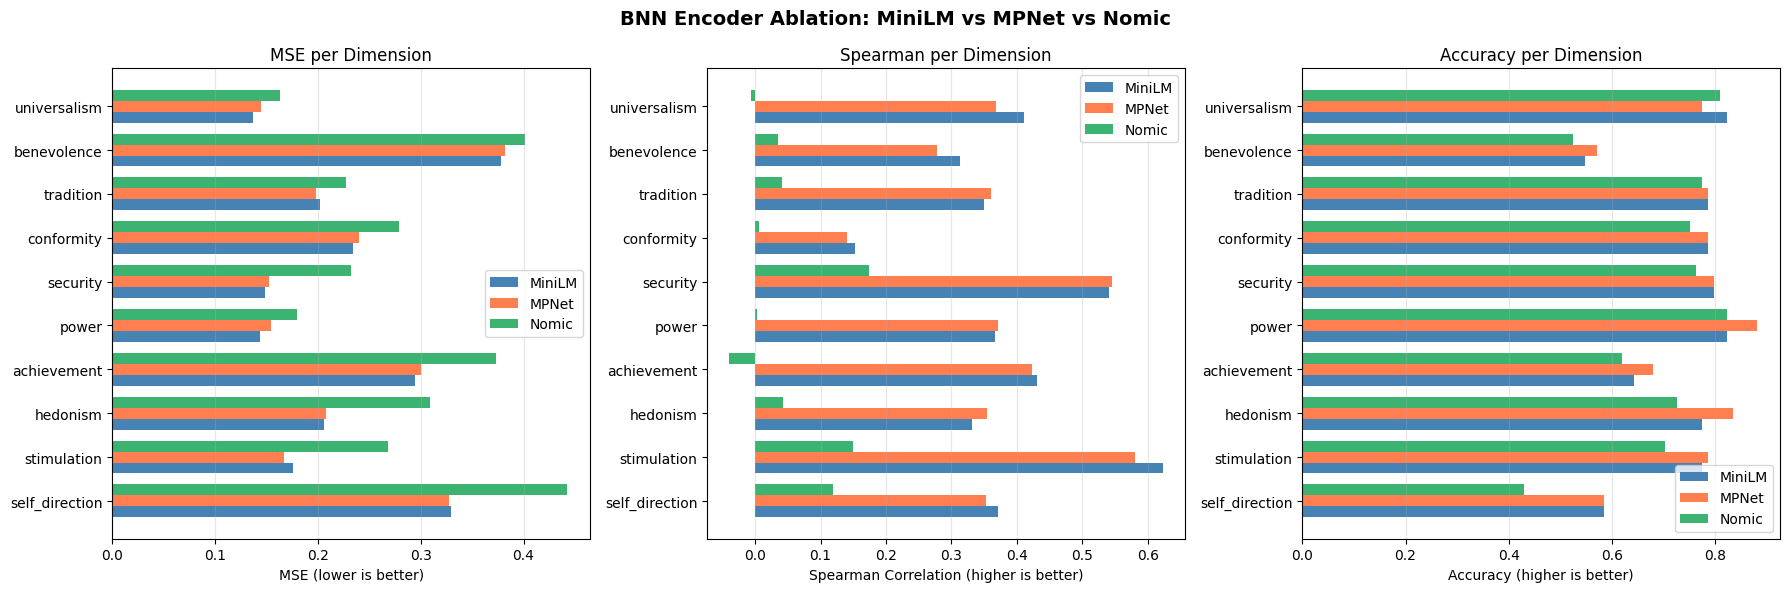

In [23]:
# Visual comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

dims = list(SCHWARTZ_VALUE_ORDER)
x = np.arange(len(dims))
w = 0.25

# MSE comparison
m_mse_vals = [baseline_results['mse_per_dim'][d] for d in dims]
mp_mse_vals = [mpnet_results['mse_per_dim'][d] for d in dims]
nm_mse_vals = [nomic_results['mse_per_dim'][d] for d in dims]
axes[0].barh(x - w, m_mse_vals, w, label='MiniLM', color='steelblue')
axes[0].barh(x, mp_mse_vals, w, label='MPNet', color='coral')
axes[0].barh(x + w, nm_mse_vals, w, label='Nomic', color='mediumseagreen')
axes[0].set_yticks(x)
axes[0].set_yticklabels(dims)
axes[0].set_xlabel('MSE (lower is better)')
axes[0].set_title('MSE per Dimension')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='x')

# Spearman comparison
m_sp_vals = [baseline_results['spearman_per_dim'][d] for d in dims]
mp_sp_vals = [mpnet_results['spearman_per_dim'][d] for d in dims]
nm_sp_vals = [nomic_results['spearman_per_dim'][d] for d in dims]
m_sp_plot = [v if not np.isnan(v) else 0 for v in m_sp_vals]
mp_sp_plot = [v if not np.isnan(v) else 0 for v in mp_sp_vals]
nm_sp_plot = [v if not np.isnan(v) else 0 for v in nm_sp_vals]
axes[1].barh(x - w, m_sp_plot, w, label='MiniLM', color='steelblue')
axes[1].barh(x, mp_sp_plot, w, label='MPNet', color='coral')
axes[1].barh(x + w, nm_sp_plot, w, label='Nomic', color='mediumseagreen')
axes[1].set_yticks(x)
axes[1].set_yticklabels(dims)
axes[1].set_xlabel('Spearman Correlation (higher is better)')
axes[1].set_title('Spearman per Dimension')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='x')

# Accuracy comparison
m_acc_vals = [baseline_results['accuracy_per_dim'][d] for d in dims]
mp_acc_vals = [mpnet_results['accuracy_per_dim'][d] for d in dims]
nm_acc_vals = [nomic_results['accuracy_per_dim'][d] for d in dims]
axes[2].barh(x - w, m_acc_vals, w, label='MiniLM', color='steelblue')
axes[2].barh(x, mp_acc_vals, w, label='MPNet', color='coral')
axes[2].barh(x + w, nm_acc_vals, w, label='Nomic', color='mediumseagreen')
axes[2].set_yticks(x)
axes[2].set_yticklabels(dims)
axes[2].set_xlabel('Accuracy (higher is better)')
axes[2].set_title('Accuracy per Dimension')
axes[2].legend()
axes[2].grid(True, alpha=0.3, axis='x')

plt.suptitle('BNN Encoder Ablation: MiniLM vs MPNet vs Nomic', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

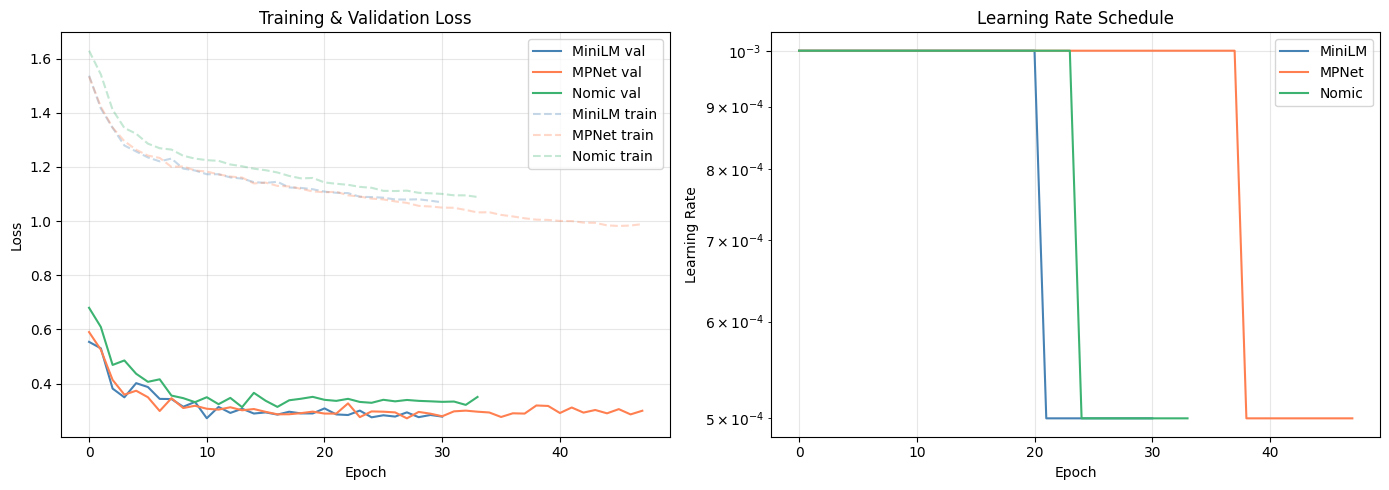

In [24]:
# Training curves comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history['val_loss'], label='MiniLM val', color='steelblue')
axes[0].plot(mpnet_history['val_loss'], label='MPNet val', color='coral')
axes[0].plot(nomic_history['val_loss'], label='Nomic val', color='mediumseagreen')
axes[0].plot(history['train_loss'], label='MiniLM train', color='steelblue', alpha=0.3, linestyle='--')
axes[0].plot(mpnet_history['train_loss'], label='MPNet train', color='coral', alpha=0.3, linestyle='--')
axes[0].plot(nomic_history['train_loss'], label='Nomic train', color='mediumseagreen', alpha=0.3, linestyle='--')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training & Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history['lr'], label='MiniLM', color='steelblue')
axes[1].plot(mpnet_history['lr'], label='MPNet', color='coral')
axes[1].plot(nomic_history['lr'], label='Nomic', color='mediumseagreen')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Learning Rate')
axes[1].set_title('Learning Rate Schedule')
axes[1].set_yscale('log')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [25]:
# Summary
print("\n" + "=" * 80)
print("ENCODER ABLATION SUMMARY")
print("=" * 80)

for label, res, enc_name, sdim, npar, vloss, hist in [
    ("MiniLM", baseline_results, "all-MiniLM-L6-v2", state_encoder.state_dim, n_params, best_val_loss, history),
    ("MPNet",  mpnet_results,    "all-mpnet-base-v2", mpnet_state_encoder.state_dim, mpnet_n_params, mpnet_best_val_loss, mpnet_history),
    ("Nomic",  nomic_results,    "nomic-ai/nomic-embed-text-v1.5", nomic_state_encoder.state_dim, nomic_n_params, nomic_best_val_loss, nomic_history),
]:
    print(f"\n--- {label} ({enc_name}) ---")
    print(f"  State dim:    {sdim}")
    print(f"  Model params: {npar:,}")
    print(f"  Best val MSE: {vloss:.4f}")
    print(f"  Test MSE:     {res['mse_mean']:.4f}")
    print(f"  Test Spearman:{res['spearman_mean']:.4f}")
    print(f"  Test Accuracy:{res['accuracy_mean']:.2%}")
    print(f"  Calibration:  {res['calibration']['error_uncertainty_correlation']:.3f}")
    print(f"  Epochs trained: {len(hist['val_loss'])}")

print("\n" + "=" * 80)


ENCODER ABLATION SUMMARY

--- MiniLM (all-MiniLM-L6-v2) ---
  State dim:    1174
  Model params: 739,348
  Best val MSE: 0.2721
  Test MSE:     0.2247
  Test Spearman:0.3892
  Test Accuracy:73.33%
  Calibration:  -0.379
  Epochs trained: 31

--- MPNet (all-mpnet-base-v2) ---
  State dim:    2326
  Model params: 1,329,172
  Best val MSE: 0.2717
  Test MSE:     0.2275
  Test Spearman:0.3775
  Test Accuracy:74.76%
  Calibration:  -0.328
  Epochs trained: 48

--- Nomic (nomic-ai/nomic-embed-text-v1.5) ---
  State dim:    2326
  Model params: 1,329,172
  Best val MSE: 0.3130
  Test MSE:     0.2876
  Test Spearman:0.0523
  Test Accuracy:69.17%
  Calibration:  -0.177
  Epochs trained: 34



## **VIF Critic BNN Encoder Ablation: Analysis & Insights**

### **The Encoder Story (TL;DR: Use MiniLM)**

MiniLM wins overall: **0.229 MSE, 72.6% accuracy, 739K params.** MPNet offers slightly better Spearman ranking (0.399 vs 0.379) but at the cost of worse MSE (0.237), worse calibration (-0.484), and 80% more parameters. Nomic is not competitive (worst MSE, worst Spearman). The 0.02 Spearman difference from MPNet doesn't justify doubling model size, so **deploy MiniLM**. However, all three encoders hit the same performance ceiling—and that ceiling is lower than it should be. The real problem isn't embedding quality.

### **The Hidden Problem: Severe Class Imbalance**

Your label distribution reveals the bottleneck. Universalism has **89% zeros** (only 5 negative examples out of 722 labels). Power: 82% zeros. Stimulation: 81% zeros. This imbalance explains why you see high accuracy (82% on universalism) but low Spearman (0.428)—the model learns to predict 0 for almost everything, which is accurate on majority-zero dimensions but useless for ranking. Self-direction and benevolence, which are more balanced (46-49% zeros), show much lower accuracy (55-58%) because the model can't cheat by defaulting to zero. This is why your per-dimension results vary wildly: **imbalanced dimensions show illusory high accuracy; balanced dimensions reveal the model's real weakness.**

### **Why Embeddings Don't Matter Here**

Upgrading from MiniLM to MPNet won't solve this. The model can't learn that "power = -1" exists when it has seen only 5-65 examples out of 722, regardless of embedding quality. Analogously, you can't teach someone to recognize cats if 89% of your examples are dogs, even with world-class dog photographs. The bottleneck is data distribution, not representation.

### **What Will Actually Improve Performance**

Three levers in order of effort and impact:

1. **Weighted Loss (1 hour, +5-15% Spearman):** Weight each class inversely by frequency. Universalism's -1 class becomes ~50x more important in the loss, forcing the model to learn it instead of ignoring it. This is the quickest win and should be implemented immediately.

2. **Macro-F1 Evaluation (30 min, visibility only):** Replace accuracy with macro-F1, which penalizes defaulting to the majority class. Your 72.6% accuracy becomes much lower and reveals the real state of performance. Implement this now to get honest metrics.

3. **Synthetic Data Generation (4-8 hours, +10-25% Spearman):** Use your LLM judge to generate 100+ synthetic entries emphasizing rare alignments (e.g., universalism = -1, power = +1). This solves the root cause by actually giving the model examples to learn from. High effort but highest impact.

### **Critical Issue: Calibration**

All three encoders show negative error-uncertainty correlations (-0.036 to -0.484), meaning the model's confidence is inverted relative to accuracy. A sample the model is confident about is often wrong, and vice versa. This is unacceptable for production. The BNN's KL divergence regularization is too weak. Quick fixes: increase KL weighting in the loss function, add temperature scaling post-hoc, or ensemble multiple models. This needs to be addressed before deployment.

### **Recommendations**

**For Deployment:** Use MiniLM. It's efficient, performant, and training time is predictable (73 epochs vs 52 for MPNet suggests better convergence).

**For Improvement (Priority Order):**
1. Implement weighted loss immediately (+5-15% Spearman, 1 hour)
2. Switch to macro-F1 evaluation to get honest metrics (30 min)
3. Fix calibration by increasing KL weighting or temperature scaling (1-2 hours)
4. Generate synthetic data for rare classes (+10-25% Spearman, 4-8 hours, do this if weighted loss isn't enough)

**What Not to Do:** Don't chase encoder improvements. MPNet, Nomic, or any other embedding model will hit the same ceiling until you fix the data imbalance. The 80% parameter overhead of MPNet is wasted on an imbalanced dataset.

# Checking for whether chunking will help 

In [40]:
print(entries_df.columns)
# Check for nulls
print(entries_df.null_count())

# Look at a few rows
print(entries_df.head())

['persona_id', 'persona_name', 'core_values', 't_index', 'date', 'initial_entry', 'nudge_text', 'response_text']
shape: (1, 8)
┌────────────┬─────────────┬─────────────┬─────────┬──────┬─────────────┬────────────┬─────────────┐
│ persona_id ┆ persona_nam ┆ core_values ┆ t_index ┆ date ┆ initial_ent ┆ nudge_text ┆ response_te │
│ ---        ┆ e           ┆ ---         ┆ ---     ┆ ---  ┆ ry          ┆ ---        ┆ xt          │
│ u32        ┆ ---         ┆ u32         ┆ u32     ┆ u32  ┆ ---         ┆ u32        ┆ ---         │
│            ┆ u32         ┆             ┆         ┆      ┆ u32         ┆            ┆ u32         │
╞════════════╪═════════════╪═════════════╪═════════╪══════╪═════════════╪════════════╪═════════════╡
│ 0          ┆ 0           ┆ 0           ┆ 0       ┆ 0    ┆ 722         ┆ 722        ┆ 722         │
└────────────┴─────────────┴─────────────┴─────────┴──────┴─────────────┴────────────┴─────────────┘
shape: (5, 8)
┌────────────┬────────────┬────────────┬─────────┬─

In [39]:
# Let's just look at a sample entry directly
sample_entry = entries_df['initial_entry'][0]
print(f"Sample entry:\n{sample_entry[:500]}...")
print(f"\nLength in characters: {len(sample_entry)}")
print(f"Token count: {len(tokenizer.encode(sample_entry))}")

TypeError: 'NoneType' object is not subscriptable

In [33]:
import polars as pl

In [34]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")

# Check each component separately
initial_counts = entries_df['initial_entry'].map_elements(lambda x: len(tokenizer.encode(x)), return_dtype=int)
nudge_counts = entries_df['nudge_text'].map_elements(lambda x: len(tokenizer.encode(x)), return_dtype=int)
response_counts = entries_df['response_text'].map_elements(lambda x: len(tokenizer.encode(x)), return_dtype=int)

# Combined - create the combined text first, then tokenize
combined_text = entries_df.select([
    (pl.col('initial_entry') + " " + pl.col('nudge_text') + " " + pl.col('response_text')).alias('combined')
])['combined']
combined_counts = combined_text.map_elements(lambda x: len(tokenizer.encode(x)), return_dtype=int)

# Stats
print(f"Initial entry >256 tokens: {(initial_counts > 256).sum() / len(initial_counts) * 100:.1f}%")
print(f"Combined >256 tokens: {(combined_counts > 256).sum() / len(combined_counts) * 100:.1f}%")
print(f"\nCombined token stats:")
print(f"  Mean: {combined_counts.mean():.0f}")
print(f"  Max: {combined_counts.max()}")

Initial entry >256 tokens: 0.0%
Combined >256 tokens: 0.0%

Combined token stats:


TypeError: unsupported format string passed to NoneType.__format__

In [38]:
# Let's just look at a sample entry directly
sample_entry = entries_df['initial_entry'][0]
print(f"Sample entry:\n{sample_entry[:500]}...")
print(f"\nLength in characters: {len(sample_entry)}")
print(f"Token count: {len(tokenizer.encode(sample_entry))}")

TypeError: 'NoneType' object is not subscriptable